In [141]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer 
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud,ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [61]:
# Load data
lyrics = pd.read_csv('lyrics.csv',index_col=0).reset_index(drop=True)
lyrics.head()

,song,year,artist,genre,lyrics
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...


In [76]:
# Covert text to lower cases:
def lower_case(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove punctuation
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove number 
def remove_number(words):
    new_words = []
    for word in words:
        if word.isdigit() == False:
            new_words.append(word)
    return new_words

# Remove stop words:
## We Use the stop word package from R pacakage since it's better
stopword = pd.read_csv('stop_word.csv',index_col=0).reset_index(drop=True)
stopword = list(stopword['stop_words'])
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopword and len(word) > 3:
            new_words.append(word)
    return new_words

# Stemming
def stem_words(words):
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

# lemmatization
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# Define finally pre-processing steps as one function
def pre_process(words):
    tk = WhitespaceTokenizer()
    word = tk.tokenize(words)
    word = lower_case(word)
    word = remove_punctuation(word)
    word = remove_number(word)
    word = remove_stopwords(word)
    word = stem_words(word)
    #words = lemmatize_verbs(words)
    return word
    

In [77]:
%%time
lyrics['stemmedword'] = ""
lyrics['stemmedword'] = lyrics.apply(lambda x:pre_process(x['lyrics']),axis=1)

CPU times: user 6min 3s, sys: 7.2 s, total: 6min 10s
Wall time: 6min 15s


In [78]:
lyrics.head()

,song,year,artist,genre,lyrics,stemmedword,sentiment
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...,"[stop, hous, call, home, rundown, grass, overg...",negative
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,"[unsur, hand, lead, danc, floor, music, die, e...",positive
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,"[mark, sunday, footbal, boot, pitch, peopl, ga...",negative
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,"[chris, fallin, fantasi, threw, destini, stop,...",neutral
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...,"[touch, hold, hand, hold, someth, chang, somet...",negative


In [16]:
## Construct stemmed word dictionary
lyrics_list = [' '.join(lyrics['lyrics'])]
stem_dict = {}
tk = WhitespaceTokenizer()
lyrics_list = tk.tokenize(lyrics_list[0])
lyrics_list = lower_case(lyrics_list)
lyrics_list = remove_punctuation(lyrics_list)
lyrics_list = remove_number(lyrics_list)
lyrics_list = remove_stopwords(lyrics_list)
stem_dict = {}
for word in lyrics_list:
    stemmer = SnowballStemmer('english')
    stems = stemmer.stem(word)
    stem_dict[stems] = word

In [79]:
## map stemmedword back to its original words
def stem_word_reverse(words):
    list = []
    for word in words:
        list.append(stem_dict[word])
    return list

lyrics['stemmedword'] = lyrics.apply(lambda x: stem_word_reverse(x['stemmedword']),axis=1)

### Basic Wordcloud

In [80]:
## define wordcloud function
def show_wordcloud(genre):

    data = lyrics[lyrics['genre'] == genre]
    word_list = []
    for i in data.index:
        word_list.extend(data['stemmedword'][i])
    unique_string=(" ").join(word_list)
    
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        scale=3,
        random_state=1 
    ).generate(str(unique_string))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title('Wordcloud for {}'.format(genre), fontsize=20)

    plt.imshow(wordcloud)
    plt.show()

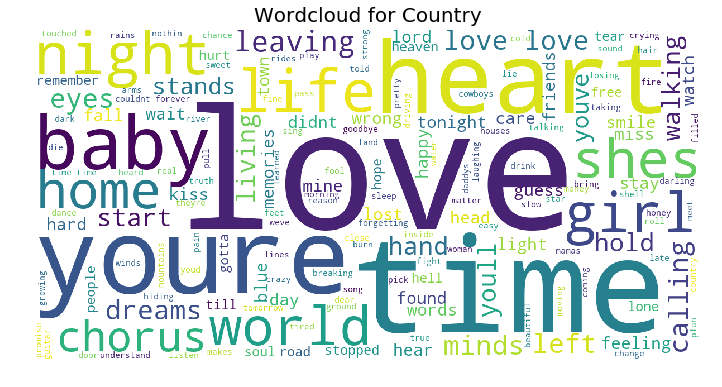

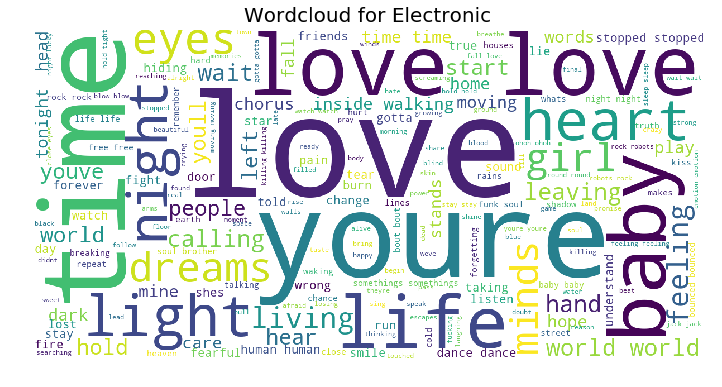

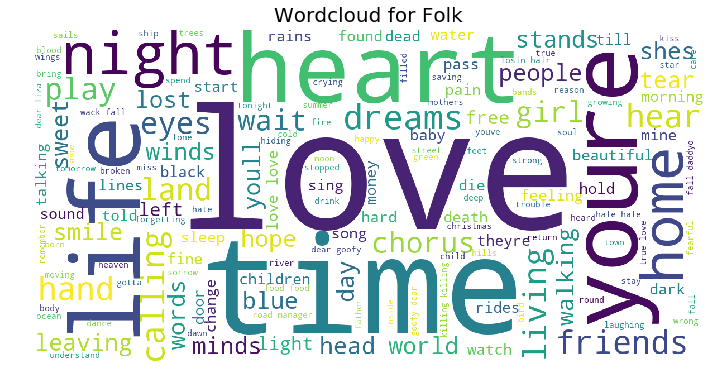

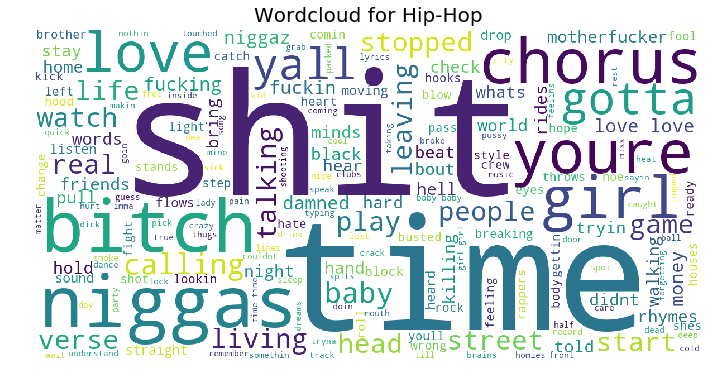

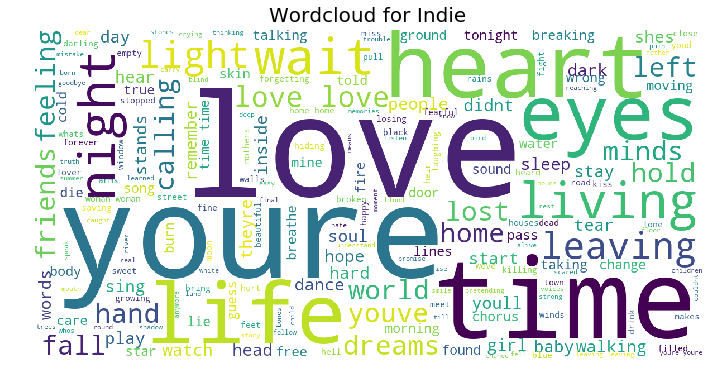

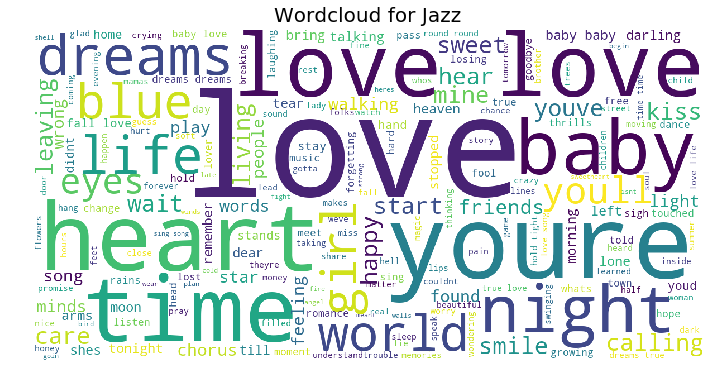

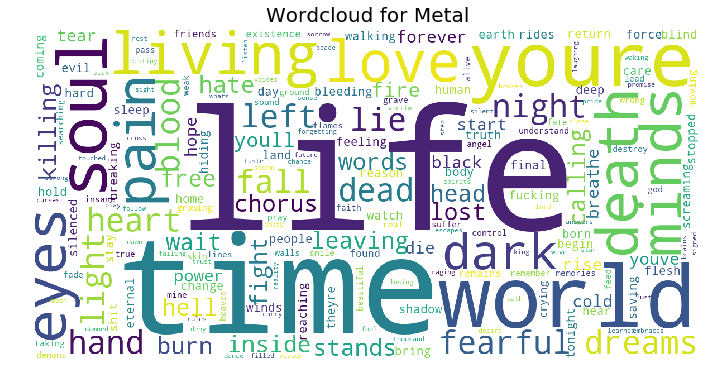

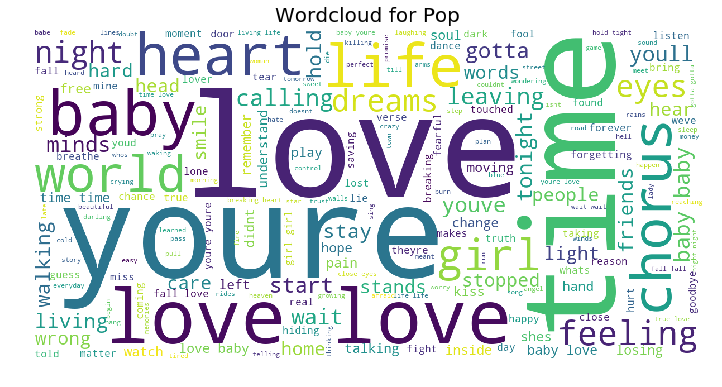

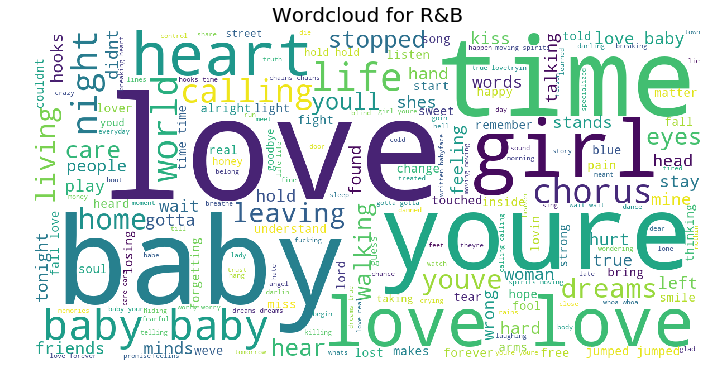

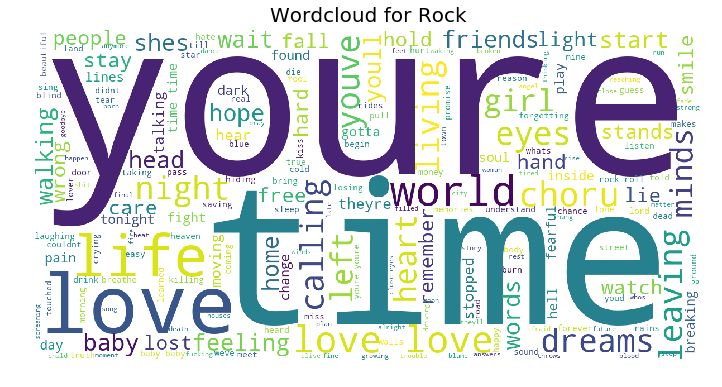

In [81]:
show_wordcloud('Country')
show_wordcloud('Electronic')
show_wordcloud('Folk')
show_wordcloud('Hip-Hop')
show_wordcloud('Indie')
show_wordcloud('Jazz')
show_wordcloud('Metal')
show_wordcloud('Pop')
show_wordcloud('R&B')
show_wordcloud('Rock')

#### We construct wordcloud for each genre, and as you may see, the word 'love' is quite popular in most of the genre songs' lyrics. Hip-hop lyrics contain a lot of curse words and slangs, whereas mental lyrics seems to contain a lot of negative words, such as 'dark','burn','dead', and 'pain'. But this doesn't seem to be enough, since there are a lot of similiarities among genres like Country, Electronic, Folk, Indie, Jazz, R&B, and Pop, we still can't really find the specialities in the lyrics of those genres. Therefore, I decide to introduce the concept of TGI (Target Group Index) to find the special words in lyrics among all those genres. The method works in the following way:
  - 1. Calculate the frequency of each word in each genre as 'word_freq_genre'.
  - 2. Calculate the frequency of each word in the entire dataset regardless of genre as 'word_freq_all'.
  - 3. Divide 'word_freq_all' by 'word_freq_genre' as 'tgi' for each word. 
  - 4. Keep the words which tgi value is bigger than 1. 

#### Let's take an example, if the word 'rocknroll' is the special words in the genre of 'Rock', then the frequency of its appearance should be higher in the lyrics of Rock songs than in the lyrics of all other genres' songs. Therefore, we are expected to see a high tgi for the word 'rocknroll' in the genre of Rock.

### TGI Wordcloud

In [164]:
def count(my_list):
    # Creating an empty dictionary  
    count = {} 
    for item in my_list: 
        if (item in count): 
            count[item] += 1
        else: 
            count[item] = 1
    return(count)

def word_freq(genre= None):
    segments_list = lyrics['stemmedword']
    if genre:
        data = lyrics[lyrics['genre'] == genre]
        segments_list = data['stemmedword']
    
    ### obtain all words in the list
    word_list = []
    for i in segments_list.index:
        word_list.extend(segments_list[i])
    
    ### calculate each word occurrences
    count_result = pd.DataFrame.from_dict(count(word_list),orient='index').reset_index()
    count_result.columns = ['word','count']

    #### calculate word frequency
    count_result['freq'] = ""
    count_result['freq'] = count_result['count']/(count_result['count'].sum())
    
    return(count_result.sort_values('freq',ascending=False).reset_index(drop=True))

def tgi_cal(freq_df):
    freq_df = freq_df[freq_df['count'] > 20]
    all_freq = word_freq()
    tgi_df = pd.merge(freq_df,all_freq,on='word',how='inner')
    tgi_df['tgi'] = tgi_df['freq_x']/tgi_df['freq_y']
    tgi_df = tgi_df[tgi_df['tgi'] >1]
    tgi_df = tgi_df[tgi_df['count_y'] >50]
    tgi_df = tgi_df[tgi_df['count_x'] != tgi_df['count_y']]
    return tgi_df.sort_values('tgi',ascending=False).reset_index(drop=True)

def tgi_wordcloud(genre):
    freq_df = word_freq(genre=genre)
    tgi_df = tgi_cal(freq_df)[['word','tgi']]
    tgi = tgi_df.set_index('word')['tgi'].to_dict()
    
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        scale=3,
        random_state=1 
    ).generate_from_frequencies(frequencies=tgi)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title('TGI Wordcloud for {}'.format(genre), fontsize=20)

    plt.imshow(wordcloud)
    plt.show()

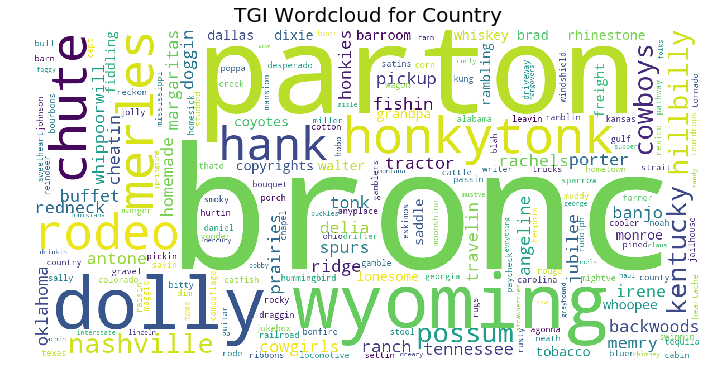

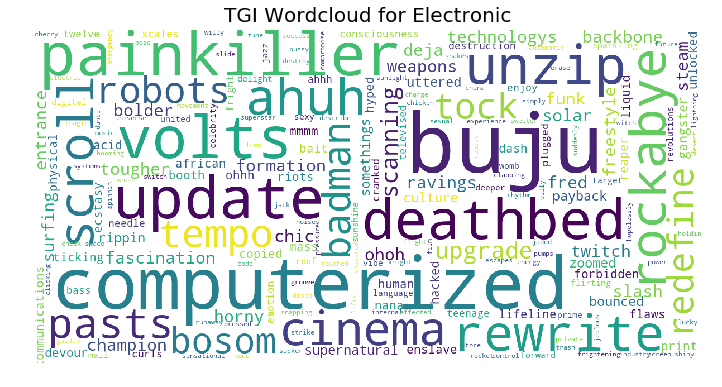

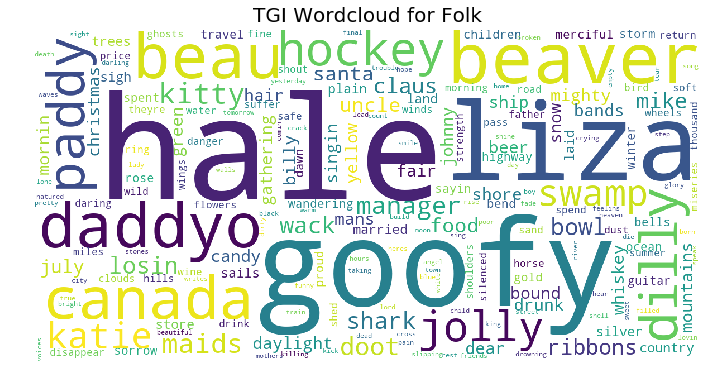

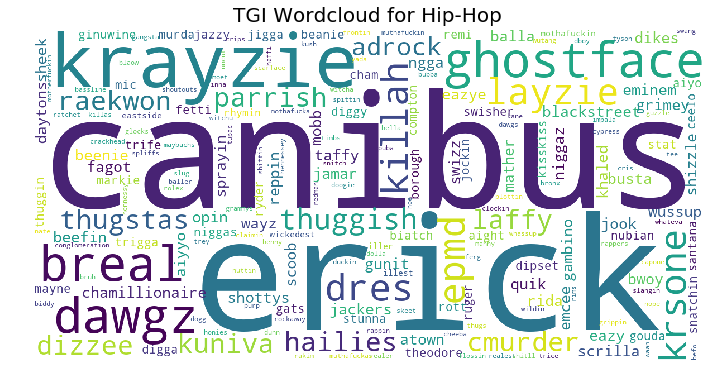

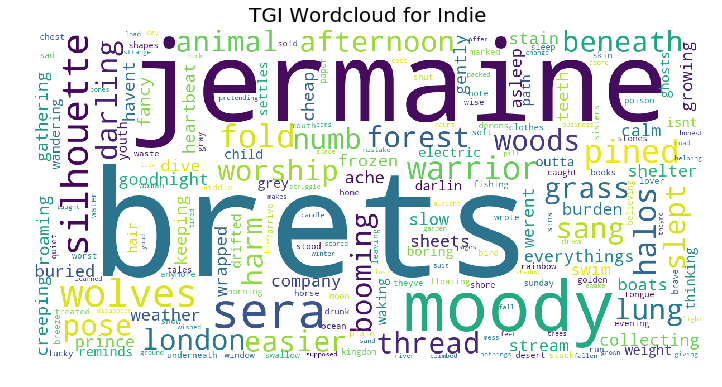

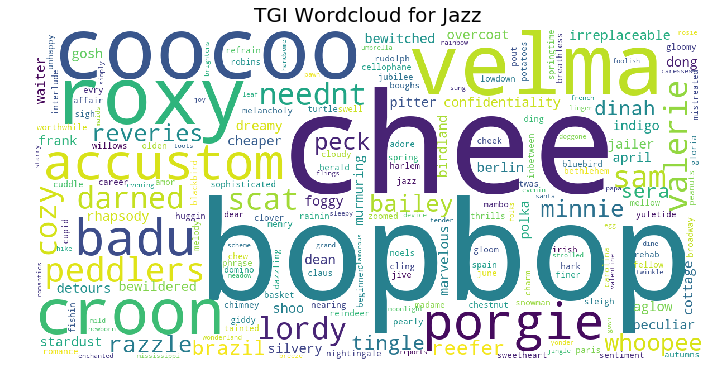

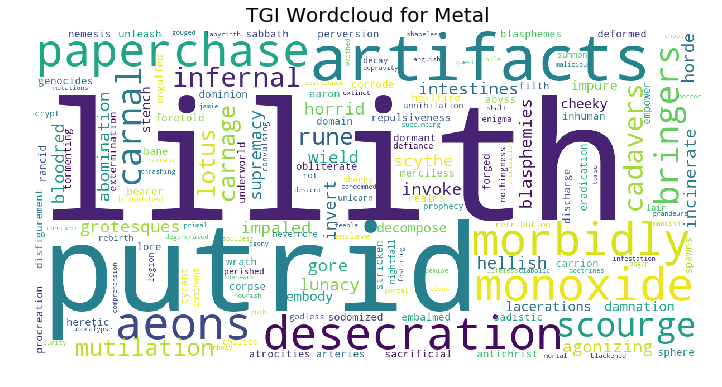

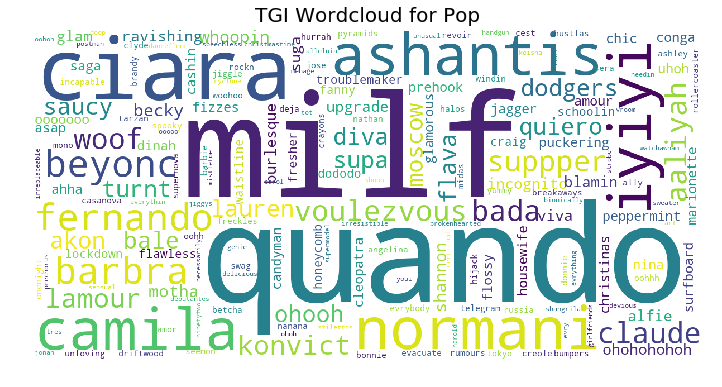

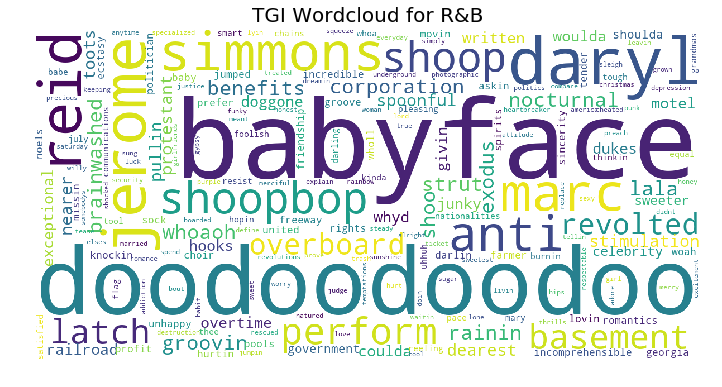

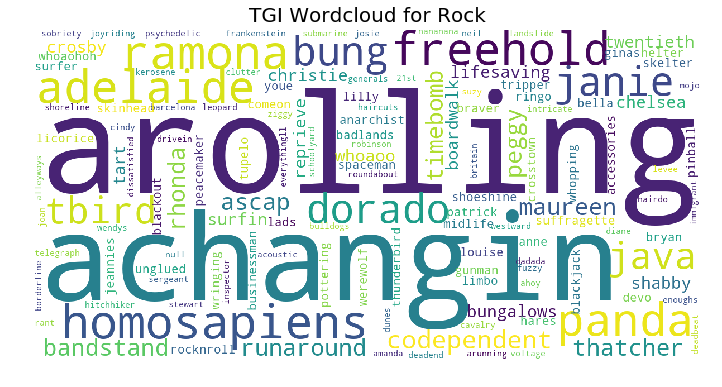

In [165]:
tgi_wordcloud('Country')
tgi_wordcloud('Electronic')
tgi_wordcloud('Folk')
tgi_wordcloud('Hip-Hop')
tgi_wordcloud('Indie')
tgi_wordcloud('Jazz')
tgi_wordcloud('Metal')
tgi_wordcloud('Pop')
tgi_wordcloud('R&B')
tgi_wordcloud('Rock')

#### The TGI wordcloud could tell us more data stories inside the lyrics. For example, in Country music, we can find a lot of location words, such as 'wyoming','kentucky','nashville',and 'tennessee'. and those locations are most popular places for country music. In addition, we could also find some really popular words from the country music lyrics, such as 'bronc','rodeo','dolly','cowboys',and 'honky-tonk'. For Folk music, without knowing anything about folk music, we found several canadian-related elements in the lyrics, such as, 'canada', 'beaver', and 'hockey'. So it turns out folk music is quite popular in Canada. In Hip-hop, there are a lot of slang words and curse words. In addition, there are also a lot of musician names, such as 'ghostface','canibus',and 'krsone'.

### Sentiment Analysis 

In [73]:
# Set up function for sentiment analysis
def senti_analyzer(text):
    sia = SentimentIntensityAnalyzer()
    comp = sia.polarity_scores(text)
    comp = comp['compound']
    if comp >= 0.5:
        return 'positive'
    elif comp > -0.5 and comp < 0.5:
        return 'neutral'
    else:
        return 'negative'

In [74]:
lyrics['sentiment'] = ""
lyrics['sentiment'] = lyrics.apply(lambda x: senti_analyzer(x['lyrics']),axis=1)

In [133]:
sentiment_df = lyrics.groupby(['genre','sentiment']).count()['song']
sentiment_df = pd.DataFrame(sentiment_df)
sentiment_df = sentiment_df.reset_index()
sentiment_df = sentiment_df.pivot_table(index='genre', columns='sentiment', values='song')
sentiment_df = sentiment_df.apply(lambda x: (x/x.sum())*100,axis=1)

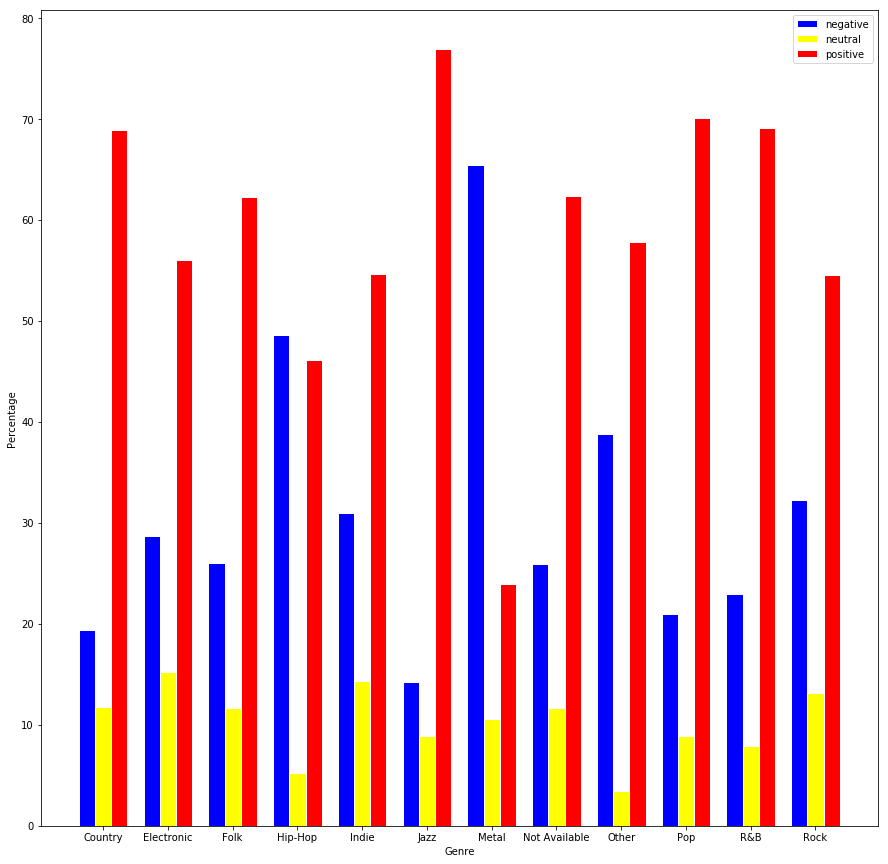

In [166]:
barWidth = 0.25
bars1 = sentiment_df['negative']
bars2 = sentiment_df['neutral']
bars3 = sentiment_df['positive']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.figure(figsize=(15,15))
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='negative')
plt.bar(r2, bars2, color='yellow', width=barWidth, edgecolor='white', label='neutral')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='positive')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie','Jazz','Metal','Not Available','Other','Pop','R&B','Rock'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


### For sentiment analysis, we calculate the compound score for each song and categorize each song based on the score. Afterword, we compute the percentage of 'negative','neutral', and 'positive' among each genre. Based on the plot above, we can see that Jazz songs have the highest positive percentage among all genres, whereas metal songs have the highest negative percentage, following by Hip-hop. In addition, most of the genres have a higher percentage of positive sentiment songs besides Hip-hop and mental. However, it is quite surprising to see Metal songs have a higher negative percentage than Hip-hop songs given the fact that a lot of the words in hip-hop songs are slangs and curse words.